In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [2]:
import pandas as pd
import random
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [9]:
%ls

'235743_구내식당 식사 인원 예측 AI 경진대회_data.zip'   sample_data/


In [10]:
!unzip '235743_구내식당 식사 인원 예측 AI 경진대회_data.zip'

Archive:  235743_구내식당 식사 인원 예측 AI 경진대회_data.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [57]:
base_path = "."
# train 변수에 train.csv 데이터를 불러옵니다.
# test 변수에 test.csv 데이터를 불러옵니다.
# submission 변수에 sample_submission.csv 데이터를 불러옵니다.
train = pd.read_csv(f'{base_path}/train.csv')
test = pd.read_csv(f'{base_path}/test.csv')
submission = pd.read_csv(f'{base_path}/sample_submission.csv')



train.shape, test.shape, submission.shape

((1205, 12), (50, 10), (50, 3))

In [58]:
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

In [59]:
drops = ['조식메뉴', '중식메뉴', '석식메뉴']

train = train.drop(drops, axis=1)
test = test.drop(drops, axis=1)

- 월요일에 중식계가 가장 높은 것을 알 수 있다.
- 이후 점차 떨어지는 것으로 보인다.

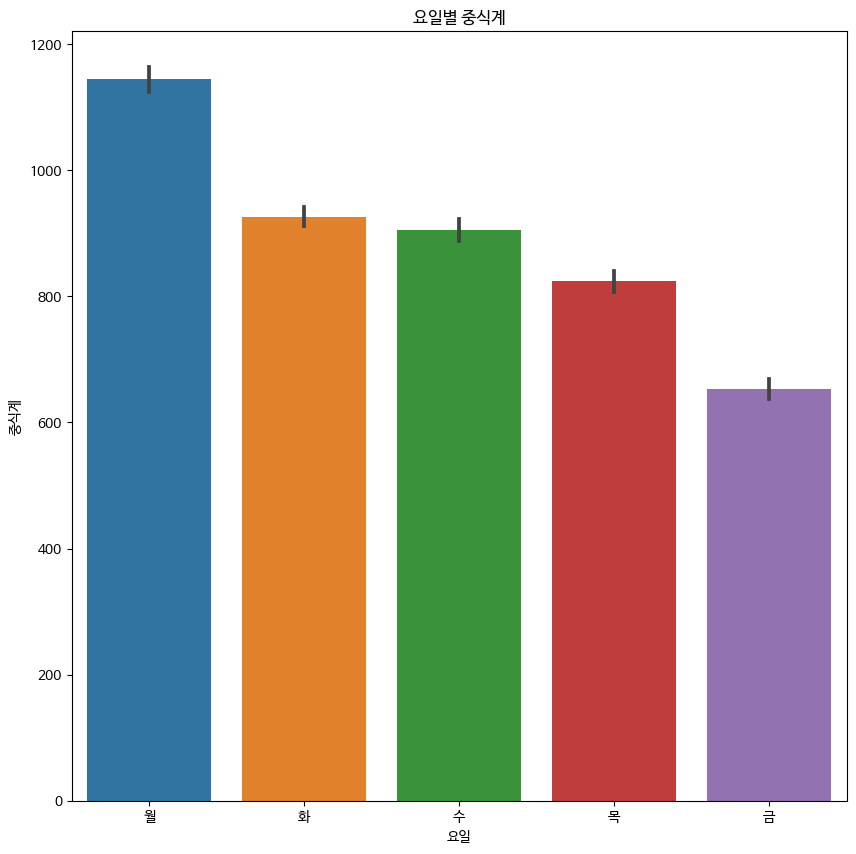

In [60]:
plt.figure(figsize=(10,10))


sns.barplot(x="요일", y="중식계", data=train)
plt.title("요일별 중식계")
plt.rc('font', family='NanumBarunGothic')
plt.show()

- 월요일이 가장 높은지수를 보인다.
- 수요일이 가장 낮은 것으로 보이며 그다음으로 금요일이 낮은 것으로 보인다.

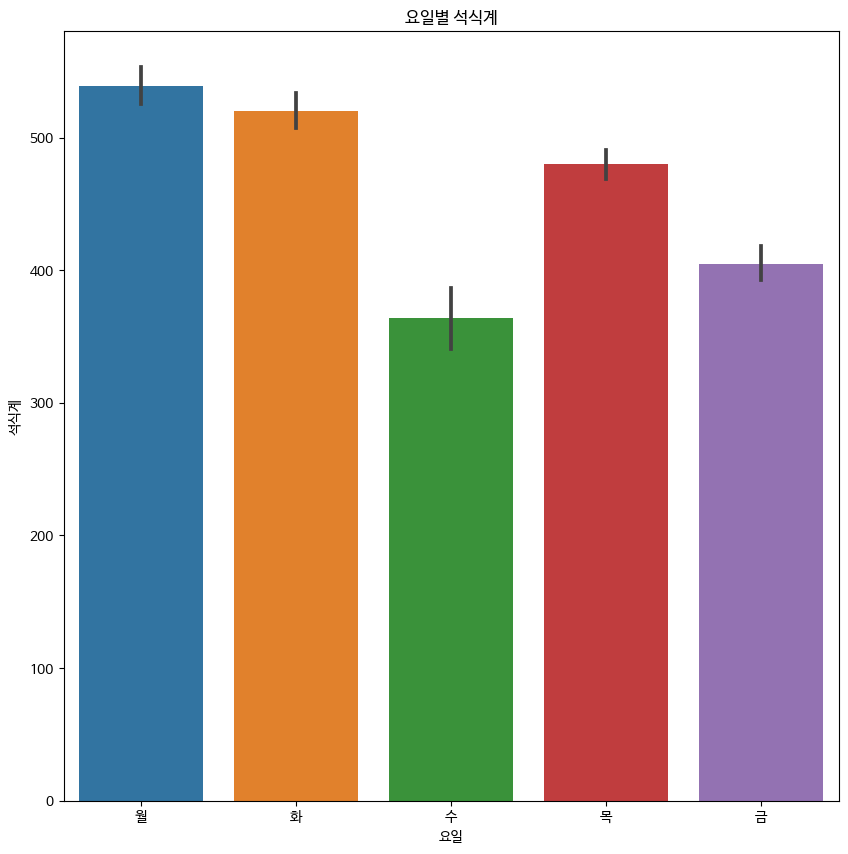

In [61]:
plt.figure(figsize=(10,10))


sns.barplot(x="요일", y="석식계", data=train)
plt.title("요일별 석식계")
plt.show()

In [62]:
train['월'] = pd.DatetimeIndex(train['일자']).month
test['월'] = pd.DatetimeIndex(test['일자']).month

train['일'] = pd.DatetimeIndex(train['일자']).day
test['일'] = pd.DatetimeIndex(test['일자']).day

In [63]:
weekday = {
    '월': 1,
    '화': 2,
    '수': 3,
    '목': 4,
    '금': 5
}

train['요일'] = train['요일'].map(weekday)
test['요일'] = test['요일'].map(weekday)

In [21]:
train.head(5)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,월,일
0,2016-02-01,1,2601,50,150,238,0.0,1039.0,331.0,2,1
1,2016-02-02,2,2601,50,173,319,0.0,867.0,560.0,2,2
2,2016-02-03,3,2601,56,180,111,0.0,1017.0,573.0,2,3
3,2016-02-04,4,2601,104,220,355,0.0,978.0,525.0,2,4
4,2016-02-05,5,2601,278,181,34,0.0,925.0,330.0,2,5


In [22]:
test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,월,일
0,2021-01-27,3,2983,88,182,5,358.0,1,27
1,2021-01-28,4,2983,104,212,409,348.0,1,28
2,2021-01-29,5,2983,270,249,0,294.0,1,29
3,2021-02-01,1,2924,108,154,538,322.0,2,1
4,2021-02-02,2,2924,62,186,455,314.0,2,2


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   int64         
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   중식계             1205 non-null   float64       
 8   석식계             1205 non-null   float64       
 9   월               1205 non-null   int64         
 10  일               1205 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(7)
memory usage: 103.7 KB


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              50 non-null     datetime64[ns]
 1   요일              50 non-null     int64         
 2   본사정원수           50 non-null     int64         
 3   본사휴가자수          50 non-null     int64         
 4   본사출장자수          50 non-null     int64         
 5   본사시간외근무명령서승인건수  50 non-null     int64         
 6   현본사소속재택근무자수     50 non-null     float64       
 7   월               50 non-null     int64         
 8   일               50 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 3.6 KB


In [25]:
train.isnull().sum().sum()

0

In [26]:
test.isnull().sum().sum()

0

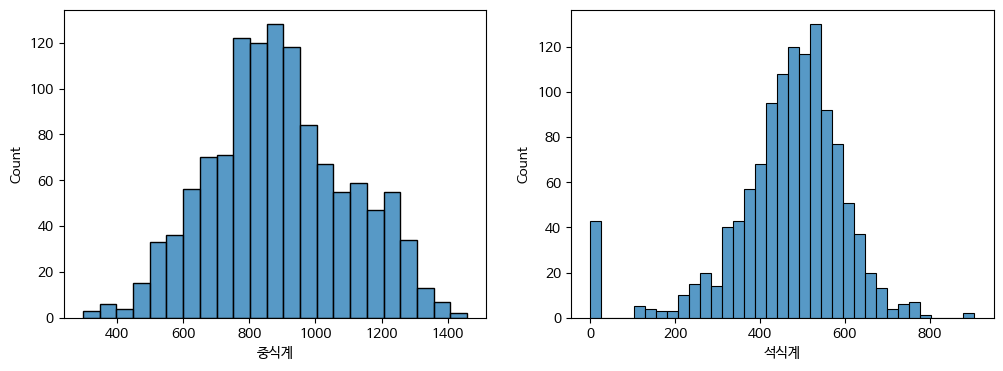

In [27]:
f,ax = plt.subplots(1,2, figsize=(12, 4))
sns.histplot(x=train['중식계'], ax=ax[0])
sns.histplot(x=train['석식계'], ax=ax[1])
plt.rc('font', family='NanumBarunGothic')

### 석식계가 0인 날
- 2017년 9월 1일은 금요일 특정한날은 아니지만 석식계가 0이다.
- 2017년 9월 29일은 추석 전 금요일로 토요일부터 다다음주 월요일까지 긴 연휴가 있었다.
- 대부분 석식계가 0인날은 수요일로 본사시간외근무명령서승인건수가 0인날이 대부분이다.
- 대부분 그달의 마지막 수요일에 석식계가 0인것을 알 수 있다.
- 2019년 12월 31일은 그 해의 마지막 날이기에 본사시간외근무명령승인건수는 22건이나 있으나 석식계가 0인것을 알 수 있다.


In [28]:
train[train['석식계'] == 0]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,월,일
204,2016-11-30,3,2689,68,207,0,0.0,1109.0,0.0,11,30
224,2016-12-28,3,2705,166,225,0,0.0,767.0,0.0,12,28
244,2017-01-25,3,2697,79,203,0,0.0,720.0,0.0,1,25
262,2017-02-22,3,2632,75,252,0,0.0,1065.0,0.0,2,22
281,2017-03-22,3,2627,53,235,0,0.0,953.0,0.0,3,22
306,2017-04-26,3,2626,45,304,0,0.0,835.0,0.0,4,26
327,2017-05-31,3,2637,43,265,0,0.0,910.0,0.0,5,31
346,2017-06-28,3,2648,58,259,0,0.0,745.0,0.0,6,28
366,2017-07-26,3,2839,254,246,0,0.0,797.0,0.0,7,26
392,2017-09-01,5,2642,177,303,45,0.0,663.0,0.0,9,1


<ipython-input-29-8c89397f80be>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['본사정원수'], ax=ax[0])


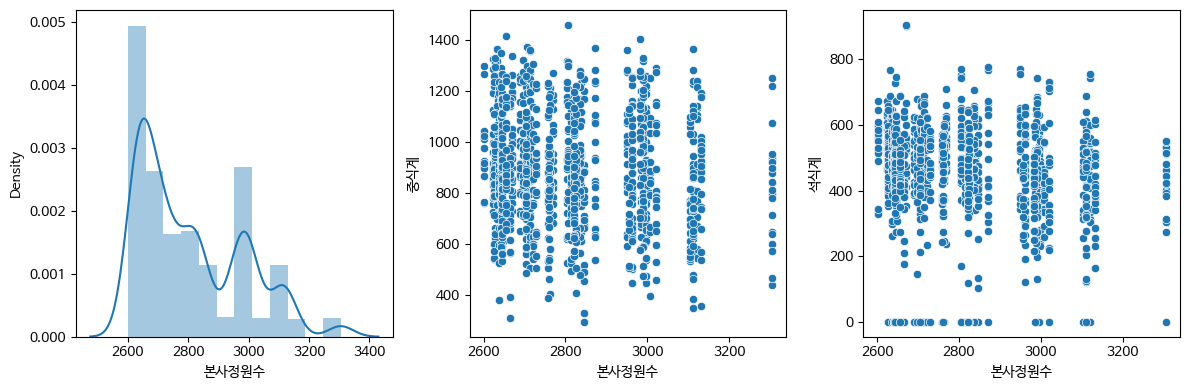

In [29]:
f, ax =plt.subplots(1,3,figsize=(12,4))
sns.distplot(train['본사정원수'], ax=ax[0])
sns.scatterplot(data=train, x='본사정원수',y='중식계',ax=ax[1])
sns.scatterplot(data=train, x='본사정원수',y='석식계',ax=ax[2])

plt.tight_layout()

In [32]:

train['출근'] = train['본사정원수']-(train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])
train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
train['출장비율'] = train['본사출장자수']/train['본사정원수']
train['야근비율'] = train['본사시간외근무명령서승인건수']/train['출근']
train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']



test['출근'] = test['본사정원수']-(test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])
test['휴가비율'] = test['본사휴가자수']/test['본사정원수']
test['출장비율'] = test['본사출장자수']/test['본사정원수']
test['야근비율'] = test['본사시간외근무명령서승인건수']/test['출근']
test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']


In [33]:
train['중식참여율'] = train['중식계'] / train['출근']
train['석식참여율'] = train['석식계'] / train['출근']

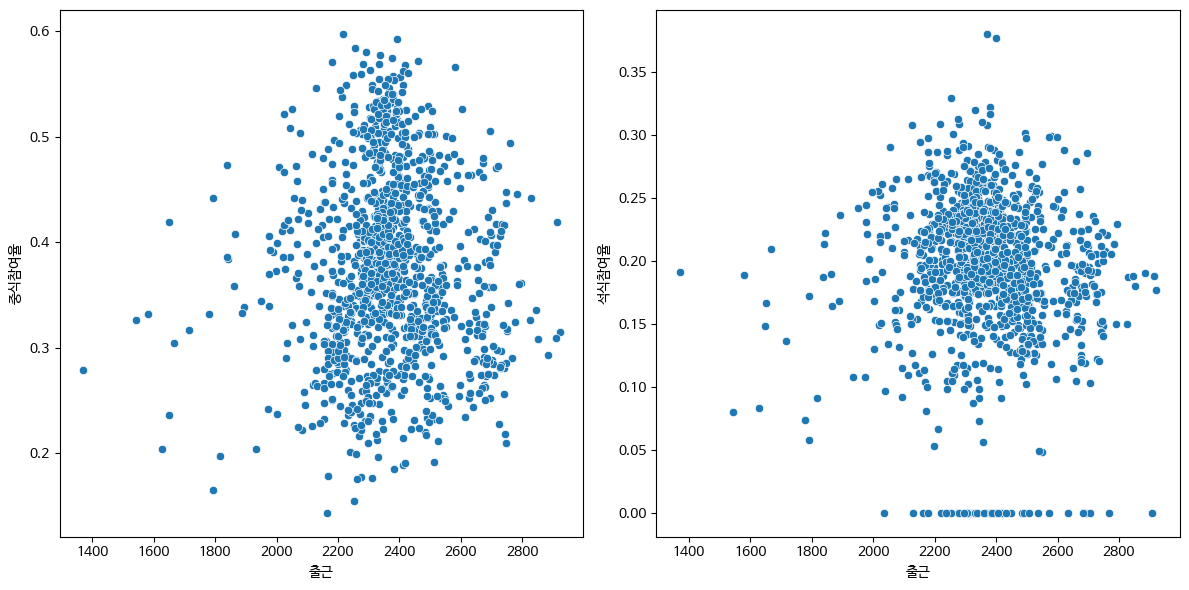

In [34]:
f, ax =plt.subplots(1,2,figsize=(12,6))
sns.scatterplot(data=train, x='출근',y='중식참여율',ax=ax[0])
sns.scatterplot(data=train, x='출근',y='석식참여율',ax=ax[1])

plt.tight_layout()

<Axes: xlabel='야근비율', ylabel='석식참여율'>

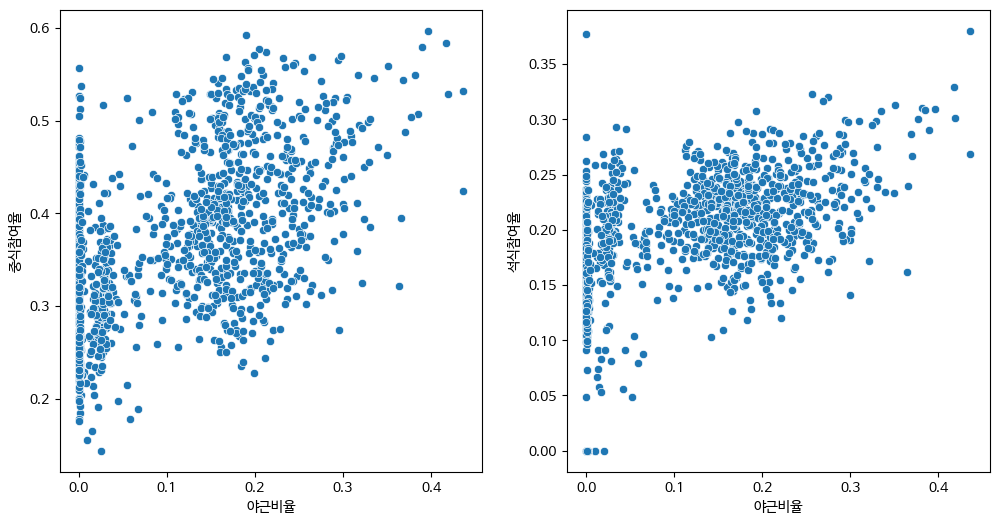

In [37]:
f, ax =plt.subplots(1,2,figsize=(12,6))
sns.scatterplot(data=train, x='야근비율',y='중식참여율',ax=ax[0])
sns.scatterplot(data=train, x='야근비율',y='석식참여율',ax=ax[1])


/usr/local/lib/python3.9/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


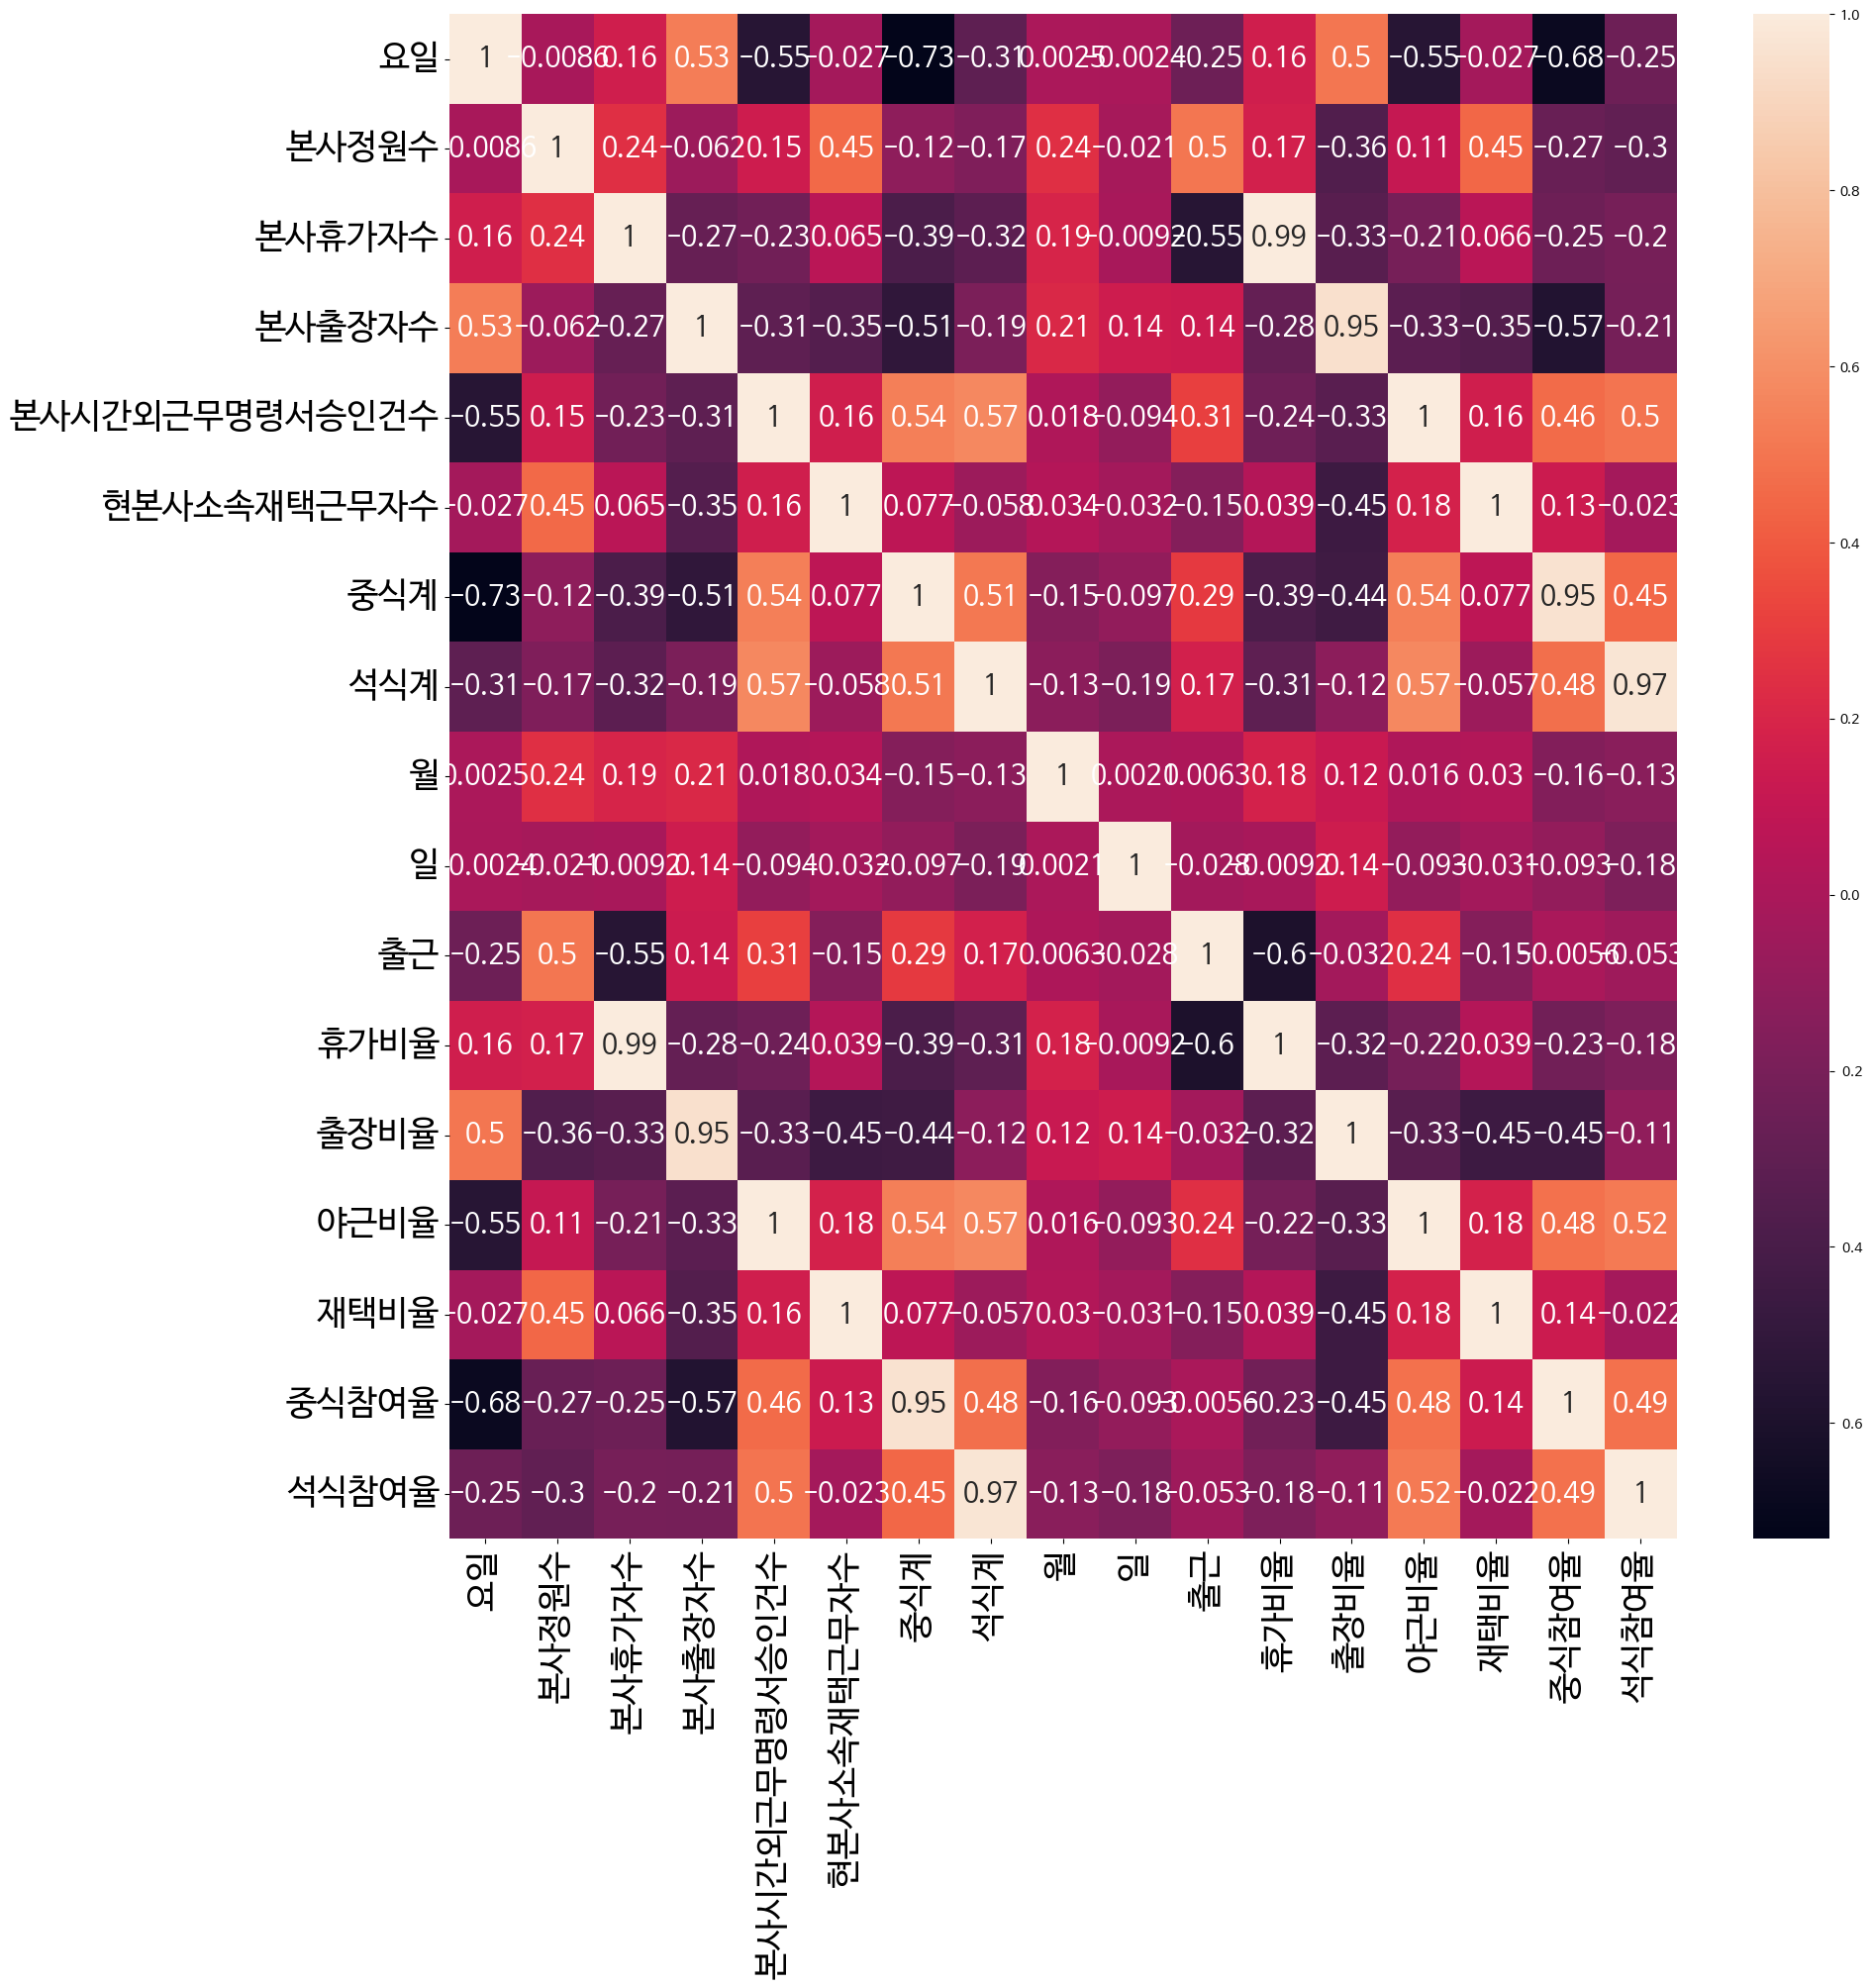

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(), annot=True, annot_kws={'size': 20}) #annot 크기 조정
plt.tick_params(labelsize=25)

- 금요일로 갈 수록 출근인원이 감소
- 금요일로 갈 수록 출장비율이 증가
- 월요일 야근비율이 가장 높다가 수요일 크게 감소하였고 목요일 다신 증가 후 금요일 다시 감소를 보임
- 금요일로 갈 수록 중식계는 감소
- 석식계는 야근비율과 비슷한 형태를 보임
- 실제 출근인원에 중식참여율은 금요일로 갈수록 점점 하락세를 보임
- 실제출근인원에 석식참여율은 수요일 큰 하락을 보인후 다시 증가하였다가 금요일 감소한다.

=> 요일별 야근비율과 석식계, 석식참여율이 비슷한 형태를 보인다.


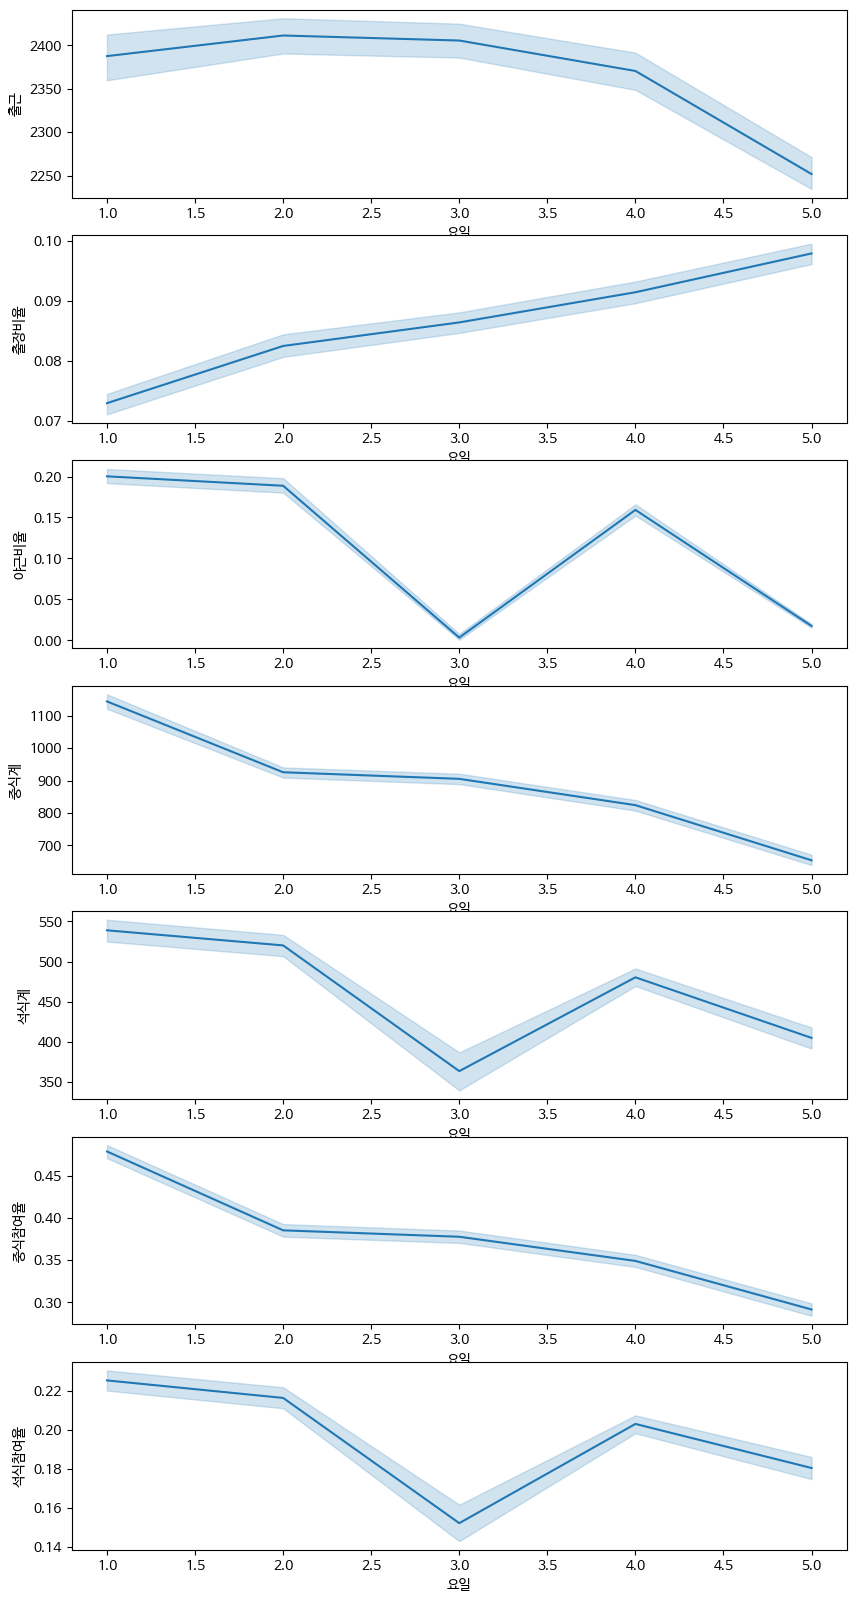

In [38]:
fig, ax = plt.subplots(7)
fig.set_size_inches(10,20)

sns.lineplot(data=train, x='요일', y='출근', ax=ax[0])
sns.lineplot(data=train, x='요일', y='출장비율', ax=ax[1])
sns.lineplot(data=train, x='요일', y='야근비율', ax=ax[2])
sns.lineplot(data=train, x='요일', y='중식계', ax=ax[3])
sns.lineplot(data=train, x='요일', y='석식계', ax=ax[4])
sns.lineplot(data=train, x='요일', y='중식참여율', ax=ax[5])
sns.lineplot(data=train, x='요일', y='석식참여율', ax=ax[6])
plt.rc('font', family='NanumBarunGothic')

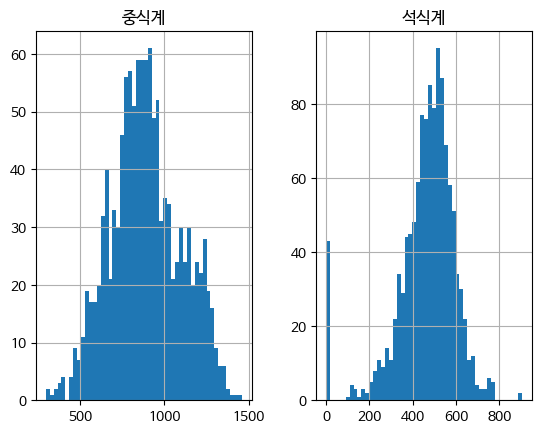

In [39]:
train[['중식계', '석식계']].hist(bins=50);

In [71]:
train = train.set_index('일자')
test = test.set_index('일자')

# GridSeach

In [41]:
label_name_1 = ['중식계']
label_name_2 = ['석식계']

In [42]:
train.columns


Index(['요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수',
       '중식계', '석식계', '월', '일', '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '중식참여율',
       '석식참여율'],
      dtype='object')

In [ ]:
feature_names = ['요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '출근', '휴가비율',
       '출장비율', '야근비율', '재택비율', '월', '일']
feature_names

['요일',
 '본사정원수',
 '본사휴가자수',
 '본사출장자수',
 '본사시간외근무명령서승인건수',
 '현본사소속재택근무자수',
 '출근',
 '휴가비율',
 '출장비율',
 '야근비율',
 '재택비율',
 '월',
 '일']

In [ ]:
X_train = train[feature_names]
print(X_train.shape)
X_train.head(2)

(1205, 13)


,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,출근,휴가비율,출장비율,야근비율,재택비율,월,일
일자,,,,,,,,,,,,,
2016-02-01,1,2601,50,150,238,0.0,2401.0,0.019223,0.057670,0.099125,0.0,2,1
2016-02-02,2,2601,50,173,319,0.0,2378.0,0.019223,0.066513,0.134146,0.0,2,2


In [ ]:
X_test = test[feature_names]
print(X_test.shape)
X_test.head(2)

(50, 13)


,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,출근,휴가비율,출장비율,야근비율,재택비율,월,일
일자,,,,,,,,,,,,,
2021-01-27,3,2983,88,182,5,358.0,2355.0,0.029501,0.061012,0.002123,0.120013,1,27
2021-01-28,4,2983,104,212,409,348.0,2319.0,0.034864,0.071069,0.176369,0.116661,1,28


In [ ]:
y_train_1 = np.log1p(train[label_name_1])
y_train_2 = np.log1p(train[label_name_2])
y_train_1.shape, y_train_2.shape

((1205, 1), (1205, 1))

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(learning_rate=0.2,
    n_estimators=200, random_state=42)
model

GradientBoostingRegressor(learning_rate=0.2, n_estimators=200, random_state=42)

In [ ]:
parameters = {"n_estimators" : (200, 300, 400), 
              "learning_rate" : (0.05, 0.1, 0.2)}
parameters

{'n_estimators': (200, 300, 400), 'learning_rate': (0.05, 0.1, 0.2)}

In [ ]:
for n_est in parameters["n_estimators"]:
    for lr in parameters["learning_rate"]:
        print(n_est, lr)

200 0.05
200 0.1
200 0.2
300 0.05
300 0.1
300 0.2
400 0.05
400 0.1
400 0.2


In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'matthews_corrcoef', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'positive_likelihood_ratio', 'neg_negative_likelihood_ratio', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weig

In [ ]:
from sklearn.model_selection import GridSearchCV

reg_1 = GridSearchCV(model, parameters, n_jobs=-1, cv=3, verbose=2, 
                   scoring="neg_root_mean_squared_error")
reg_2 = GridSearchCV(model, parameters, n_jobs=-1, cv=3, verbose=2, 
                   scoring="neg_root_mean_squared_error")

reg_1.fit(X_train, y_train_1)
reg_2.fit(X_train, y_train_2)



Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3,
             estimator=GradientBoostingRegressor(learning_rate=0.2,
                                                 n_estimators=200,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': (0.05, 0.1, 0.2),
                         'n_estimators': (200, 300, 400)},
             scoring='neg_root_mean_squared_error', verbose=2)

In [ ]:
reg_1.best_estimator_, reg_2.best_estimator_

(GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42),
 GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42))

In [ ]:
abs(reg_1.best_score_), abs(reg_2.best_score_)

(0.13381175210866547, 1.01677436964914)

In [ ]:
pd.DataFrame(reg_1.cv_results_).sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.998192,0.263157,0.005757,0.000202,0.05,200,"{'learning_rate': 0.05, 'n_estimators': 200}",-0.114648,-0.141187,-0.145600,-0.133812,0.013670,1
1,1.892743,0.138062,0.009101,0.003633,0.05,300,"{'learning_rate': 0.05, 'n_estimators': 300}",-0.114620,-0.141566,-0.146583,-0.134256,0.014035,2
2,1.763823,0.194418,0.012039,0.007397,0.05,400,"{'learning_rate': 0.05, 'n_estimators': 400}",-0.113915,-0.140994,-0.148913,-0.134608,0.014985,3


In [ ]:
pd.DataFrame(reg_2.cv_results_).sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.769456,0.020826,0.006088,0.000308,0.05,200,"{'learning_rate': 0.05, 'n_estimators': 200}",-1.212894,-0.950757,-0.886672,-1.016774,0.141124,1
1,1.086762,0.045919,0.006340,0.000093,0.05,300,"{'learning_rate': 0.05, 'n_estimators': 300}",-1.244477,-0.955683,-0.923177,-1.041112,0.144412,2
3,0.735464,0.044995,0.005865,0.000280,0.1,200,"{'learning_rate': 0.1, 'n_estimators': 200}",-1.287222,-0.968411,-0.891128,-1.048920,0.171433,3


In [ ]:
y_predict_1 = (reg_1.best_estimator_).fit(X_train, np.log1p(train["중식계"])).predict(X_test)
y_predict_2 = (reg_2.best_estimator_).fit(X_train, np.log1p(train["석식계"])).predict(X_test)

y_predict_1[:5], y_predict_2[:5]

(array([6.896092  , 6.80186502, 6.42756452, 7.12166839, 6.89136605]),
 array([3.59383582, 6.15122017, 5.54746981, 6.21997464, 6.21306279]))

<Axes: >

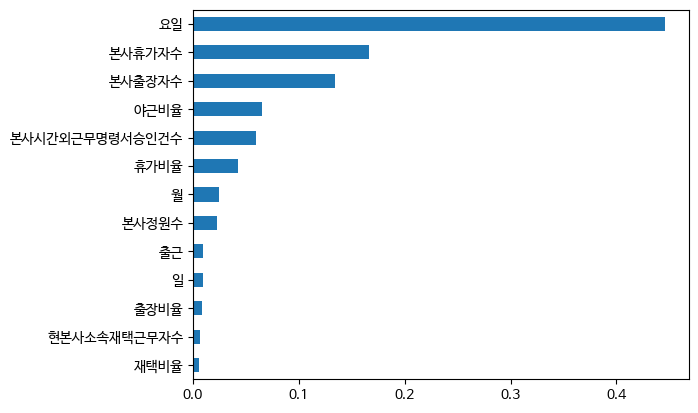

In [ ]:
fi = pd.Series(reg_1.best_estimator_.feature_importances_)
fi.index = reg_1.best_estimator_.feature_names_in_
fi.sort_values().plot.barh()

<Axes: >

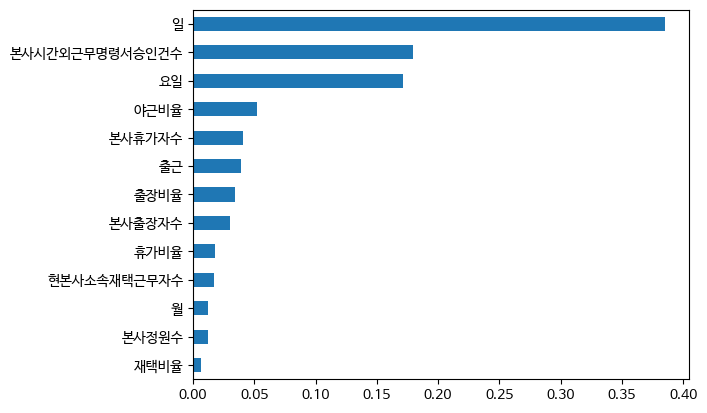

In [ ]:
fi = pd.Series(reg_2.best_estimator_.feature_importances_)
fi.index = reg_2.best_estimator_.feature_names_in_
fi.sort_values().plot.barh()

In [ ]:
df_submit = pd.read_csv(f"{base_path}/sample_submission.csv")
df_submit.head()

,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0
3,2021-02-01,0,0
4,2021-02-02,0,0


In [ ]:
y_predict_1 = np.expm1(y_predict_1)
y_predict_2 = np.expm1(y_predict_2)

y_predict_1[:5], y_predict_2[:5]

(array([ 987.40446957,  898.52335837,  617.66536273, 1237.5150404 ,
         982.74434576]),
 array([ 35.37333012, 468.28965289, 255.58751981, 501.69048145,
        498.22794426]))

In [ ]:
df_submit["중식계"] = abs(y_predict_1)
df_submit["석식계"] = abs(y_predict_2)
df_submit.head(2)

,일자,중식계,석식계
0,2021-01-27,987.404470,35.373330
1,2021-01-28,898.523358,468.289653


In [ ]:
file_name = f"{base_path}/submit.csv"
file_name

'./submit.csv'

In [ ]:
df_submit.to_csv(file_name, index=False)

In [ ]:
pd.read_csv(file_name)

,일자,중식계,석식계
0,2021-01-27,987.404470,35.373330
1,2021-01-28,898.523358,468.289653
2,2021-01-29,617.665363,255.587520
3,2021-02-01,1237.515040,501.690481
4,2021-02-02,982.744346,498.227944
5,2021-02-03,961.723617,325.425814
6,2021-02-04,918.190739,478.624800
7,2021-02-05,658.647761,298.008761
8,2021-02-08,1242.236232,540.753620
9,2021-02-09,1034.424225,504.320392


In [ ]:
from google.colab import files
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## XGBoost

In [72]:
y1 = train['중식계']
y2 = train['석식계']
X = train.drop(['중식계', '석식계'], axis=1)
X.shape, y1.shape, y2.shape

((1205, 8), (1205,), (1205,))

In [73]:
from sklearn.model_selection import train_test_split

# train_test_split?
X_train, X_valid, y1_train, y1_valid = train_test_split(X, y1, test_size=0.2, random_state=42)

# X와 y2를 분리하여 학습 데이터와 테스트 데이터로 나눕니다.
X_train, X_valid, y2_train, y2_valid = train_test_split(X, y2, test_size=0.2, random_state=42)

X_train.shape, X_valid.shape, y1_train.shape, y2_train.shape, y1_valid.shape, y2_valid.shape

((964, 8), (241, 8), (964,), (964,), (241,), (241,))

In [74]:
X_test = test
X_test.shape

(50, 8)

In [75]:
import xgboost as xgb

model_xgb1 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=250, 
                             max_depth=3,
                             random_state=42, 
                             n_jobs=-1)
                             
model_xgb1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [76]:
import xgboost as xgb

model_xgb2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=250, 
                             max_depth=3,
                             random_state=42, 
                             n_jobs=-1)
                             
model_xgb2

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [77]:
dtrain1 = xgb.DMatrix(X, label=y1)
dtrain2 = xgb.DMatrix(X, label=y2)

In [78]:
from xgboost.callback import EarlyStopping
# fit
es = xgb.callback.EarlyStopping(
    rounds=2,
    save_best=True,
    maximize=False,
    data_name="validation_0",
    metric_name="rmse",
)

model_xgb1.fit(X_train, y1_train, 
              eval_set=[(X_valid, y1_valid)], callbacks=[es])


[0]	validation_0-rmse:647.59517
[1]	validation_0-rmse:462.38178
[2]	validation_0-rmse:333.86927
[3]	validation_0-rmse:247.22210
[4]	validation_0-rmse:190.32230
[5]	validation_0-rmse:153.30140
[6]	validation_0-rmse:131.32276
[7]	validation_0-rmse:117.97747
[8]	validation_0-rmse:111.32895
[9]	validation_0-rmse:107.94731
[10]	validation_0-rmse:105.87112
[11]	validation_0-rmse:103.72885
[12]	validation_0-rmse:102.61441
[13]	validation_0-rmse:101.90640
[14]	validation_0-rmse:101.64643
[15]	validation_0-rmse:101.69013
[16]	validation_0-rmse:100.69566
[17]	validation_0-rmse:99.88823
[18]	validation_0-rmse:99.56436
[19]	validation_0-rmse:99.66868
[20]	validation_0-rmse:99.39791
[21]	validation_0-rmse:99.20964
[22]	validation_0-rmse:98.47251
[23]	validation_0-rmse:98.47927
[24]	validation_0-rmse:98.51186


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [79]:
from xgboost.callback import EarlyStopping
# fit
es = xgb.callback.EarlyStopping(
    rounds=2,
    save_best=True,
    maximize=False,
    data_name="validation_0",
    metric_name="rmse",
)

model_xgb2.fit(X_train, y2_train, 
              eval_set=[(X_valid, y2_valid)], callbacks=[es])

[0]	validation_0-rmse:344.93884
[1]	validation_0-rmse:249.51448
[2]	validation_0-rmse:186.37776
[3]	validation_0-rmse:146.04471
[4]	validation_0-rmse:119.59993
[5]	validation_0-rmse:105.26190
[6]	validation_0-rmse:96.18359
[7]	validation_0-rmse:91.05700
[8]	validation_0-rmse:88.68802
[9]	validation_0-rmse:87.49065
[10]	validation_0-rmse:86.49432
[11]	validation_0-rmse:85.74325
[12]	validation_0-rmse:85.32936
[13]	validation_0-rmse:84.43400
[14]	validation_0-rmse:83.06939
[15]	validation_0-rmse:82.54507
[16]	validation_0-rmse:82.18477
[17]	validation_0-rmse:81.45740
[18]	validation_0-rmse:81.57534
[19]	validation_0-rmse:81.67395


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [80]:
y_valid_predict1 = model_xgb1.predict(X_valid)
y_valid_predict1[:5]

array([846.2032 , 793.2238 , 844.82623, 936.9205 , 548.5121 ],
      dtype=float32)

In [81]:
y_valid_predict2 = model_xgb2.predict(X_valid)
y_valid_predict2[:5]

array([502.19724, 475.29584, 194.27776, 493.79037, 291.42828],
      dtype=float32)

<Axes: >

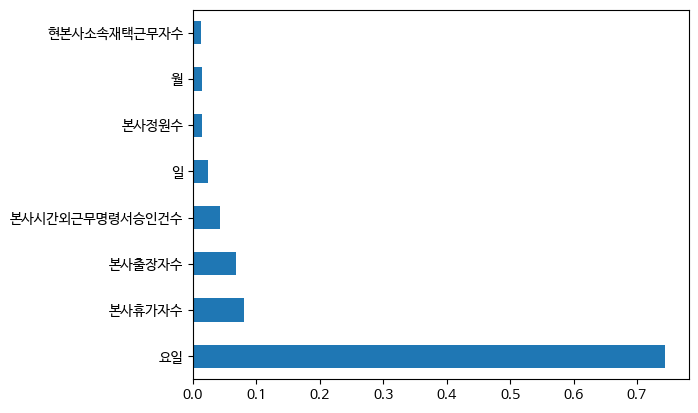

In [82]:
fi = pd.Series(model_xgb1.feature_importances_)
fi.index = model_xgb1.feature_names_in_
fi.nlargest(20).plot.barh()

<Axes: >

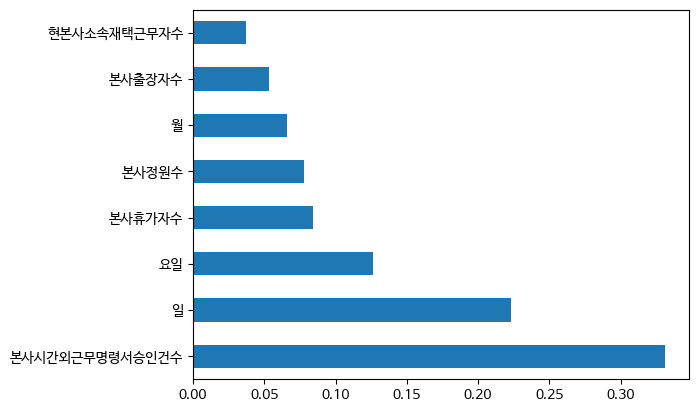

In [83]:
fi = pd.Series(model_xgb2.feature_importances_)
fi.index = model_xgb2.feature_names_in_
fi.nlargest(20).plot.barh()

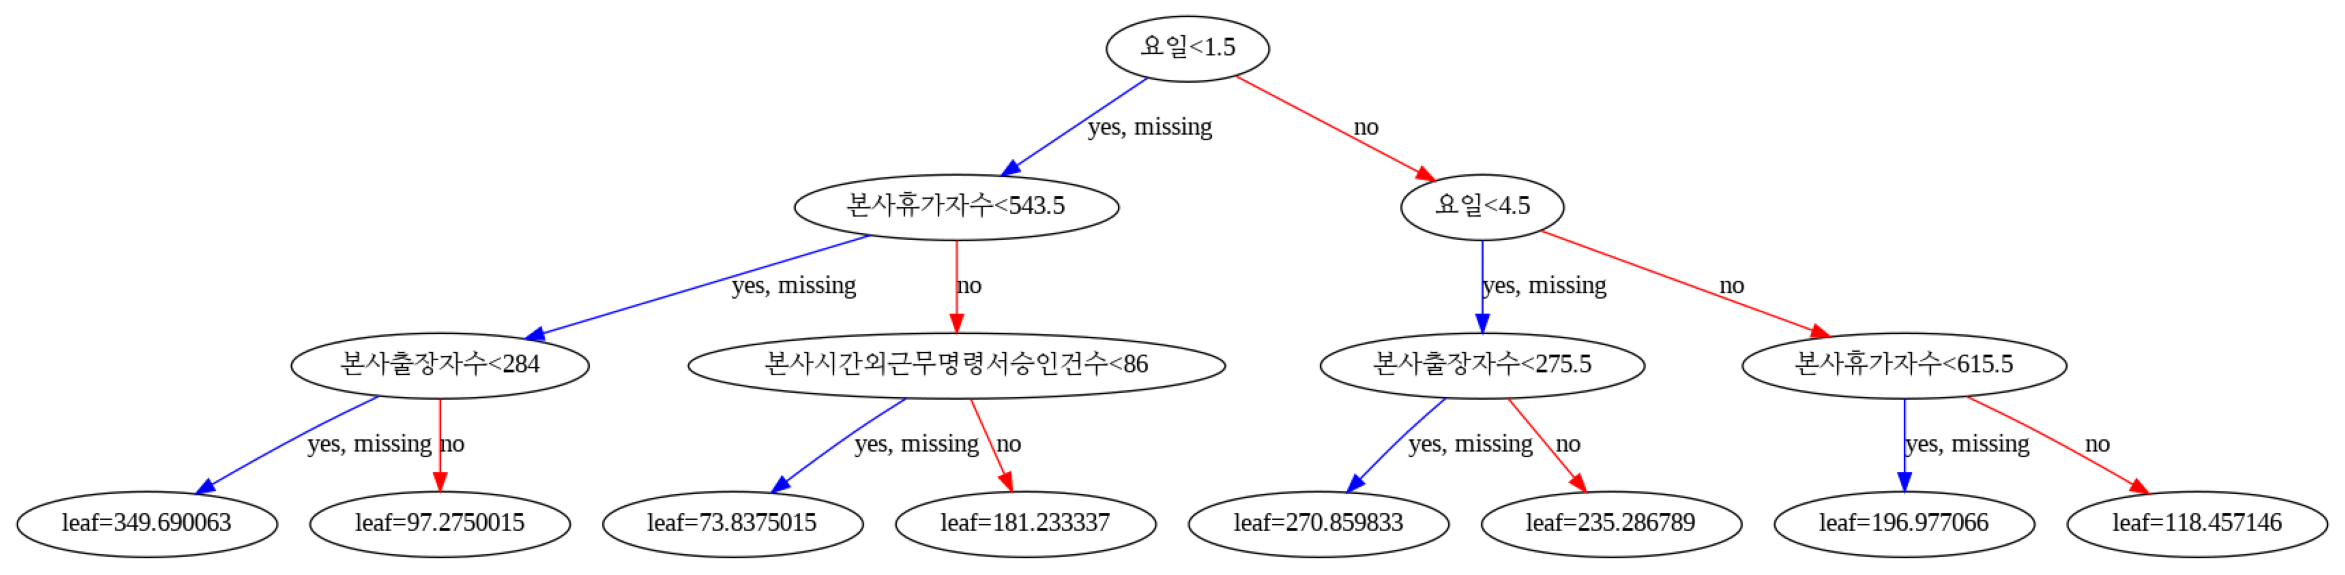

In [84]:
xgb.plot_tree(model_xgb1, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(30, 20)

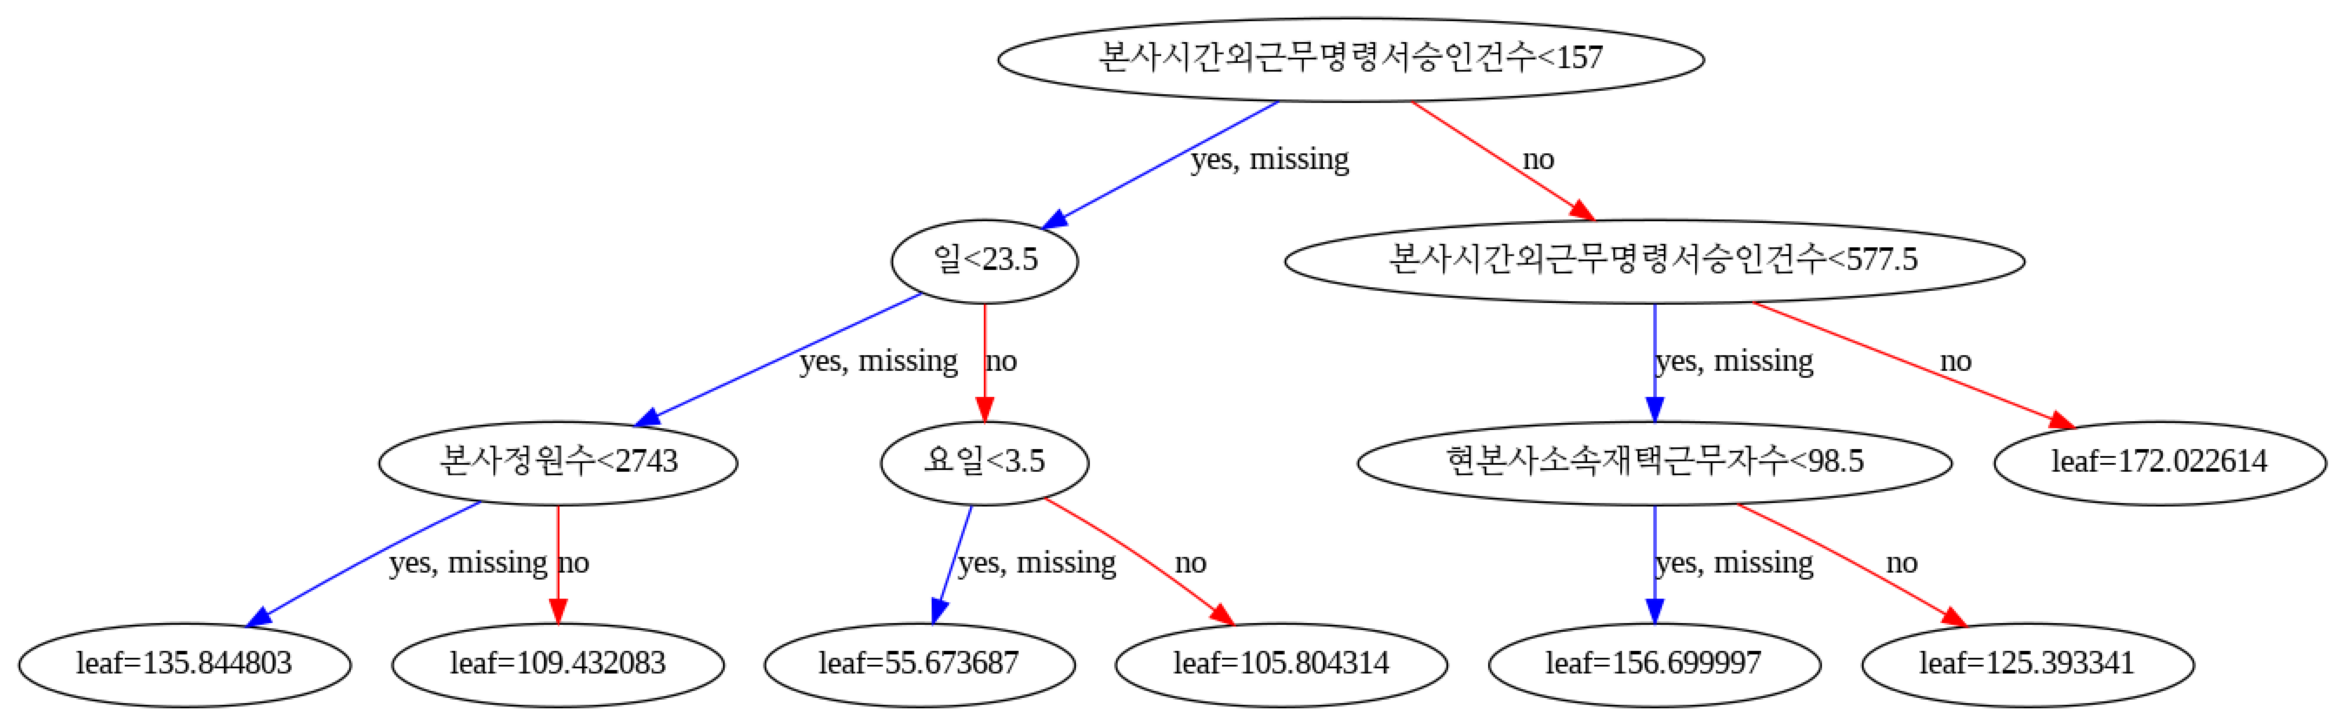

In [85]:
xgb.plot_tree(model_xgb2, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(30, 20)

In [86]:
from sklearn.metrics import r2_score
r2_score(y1_valid, y_valid_predict1)

0.7710897585592451

In [87]:
from sklearn.metrics import r2_score
r2_score(y2_valid, y_valid_predict2)

0.6654411509827254

In [88]:
score_xgb1 = model_xgb1.score(X_valid, y1_valid)
score_xgb1

0.7710897585592451

In [89]:
score_xgb2 = model_xgb2.score(X_valid, y2_valid)
score_xgb2

0.6654411509827254

In [90]:
X_test.shape

(50, 8)

In [91]:
y_pred_xgb1 = model_xgb1.predict(X_test)
y_pred_xgb1[:5]

array([ 994.07043,  896.01776,  582.4626 , 1171.337  , 1030.7476 ],
      dtype=float32)

In [92]:
y_pred_xgb2 = model_xgb2.predict(X_test)
y_pred_xgb2[:5]

array([181.77493, 417.50815, 248.2568 , 554.94135, 512.7033 ],
      dtype=float32)

In [93]:
df_submit = pd.read_csv(f"{base_path}/sample_submission.csv")
df_submit.head()

,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0
3,2021-02-01,0,0
4,2021-02-02,0,0


In [94]:
df_submit["중식계"] = abs(y_pred_xgb1)
df_submit["석식계"] = abs(y_pred_xgb2)
df_submit.head(2)

,일자,중식계,석식계
0,2021-01-27,994.070435,181.774933
1,2021-01-28,896.017761,417.508148


In [95]:
file_name = f"{base_path}/submit.csv"
file_name

'./submit.csv'

In [96]:
df_submit.to_csv(file_name, index=False)

In [97]:
pd.read_csv(file_name)

,일자,중식계,석식계
0,2021-01-27,994.07043,181.77493
1,2021-01-28,896.01776,417.50815
2,2021-01-29,582.46260,248.25680
3,2021-02-01,1171.33700,554.94135
4,2021-02-02,1030.74760,512.70330
5,2021-02-03,973.54370,394.72653
6,2021-02-04,916.97400,476.34396
7,2021-02-05,667.42523,342.26420
8,2021-02-08,1221.03340,600.12880
9,2021-02-09,1024.68470,530.98364


In [ ]:
from google.colab import files
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>